In [140]:
import argparse
import concurrent.futures
import glob
import logging
import os
import random
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import yaml
from bokeh.models import HoverTool, BoxZoomTool, ResetTool, Range1d, UndoTool, WheelZoomTool, PanTool
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from hdbscan import HDBSCAN
from ogb.graphproppred import PygGraphPropPredDataset


from torch_geometric.data import DataLoader
from torch_geometric.transforms import Compose
from tqdm import tqdm



from utils import better_to_nx
from unsupervised.embedding_evaluation_riku import GeneralEmbeddingEvaluation
from unsupervised.encoder import MoleculeEncoder
from unsupervised.learning import GInfoMinMax
from unsupervised.utils import initialize_edge_weight
from unsupervised.view_learner import ViewLearner
from datasets.loaders import get_val_loaders, get_val_datasets
from sklearn.metrics import pairwise_distances

In [2]:
def repair_config(args):
    key_names = list(args.keys())
    
    new_cfg = {}
    for key_name in key_names:
        try:
            new_cfg[key_name] = args[key_name]["value"]
        except:
            pass
    
    return new_cfg

In [3]:
checkpoint = 'Sweep-get-1.pt'
checkpoint_path = f"outputs/{checkpoint}"
cfg_name = checkpoint.split('.')[0] + ".yaml"
config_path = f"outputs/{cfg_name}"
with open(config_path, 'r') as stream:
    args = yaml.safe_load(stream)
print(args)
args = repair_config(args)
print(args)
model = GInfoMinMax(MoleculeEncoder(emb_dim=args["emb_dim"], num_gc_layers=args["num_gc_layers"], drop_ratio=args["drop_ratio"], pooling_type=args["pooling_type"]),
                    proj_hidden_dim=args["emb_dim"])

{'wandb_version': 1, '_wandb': {'desc': None, 'value': {'cli_version': '0.13.4', 'framework': 'torch', 'is_jupyter_run': False, 'is_kaggle_kernel': False, 'python_version': '3.9.13', 'start_time': 1694592645.649292, 't': {1: [1, 5, 51, 53, 55, 77], 2: [1, 5, 51, 53, 55, 77], 3: [3, 13, 16, 23, 37], 4: '3.9.13', 5: '0.13.4', 8: [5]}}}, 'batch_size': {'desc': None, 'value': 377}, 'dataset': {'desc': None, 'value': 'ogbg-molesol'}, 'drop_ratio': {'desc': None, 'value': 0.2}, 'emb_dim': {'desc': None, 'value': 321}, 'epochs': {'desc': None, 'value': 10}, 'mlp_edge_model_dim': {'desc': None, 'value': 80}, 'model_lr': {'desc': None, 'value': 0.0023717179766619165}, 'num_gc_layers': {'desc': None, 'value': 3}, 'pooling_type': {'desc': None, 'value': 'standard'}, 'reg_lambda': {'desc': None, 'value': 3.8533540784171447}, 'seed': {'desc': None, 'value': 0}, 'view_lr': {'desc': None, 'value': 0.000861296755950849}}
{'_wandb': {'cli_version': '0.13.4', 'framework': 'torch', 'is_jupyter_run': Fals

In [4]:
model_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(model_dict['encoder_state_dict'])

<All keys matched successfully>

In [6]:
my_transforms = Compose([initialize_edge_weight])

val_loaders, names = get_val_loaders(args["batch_size"], my_transforms, num=200)
val_datasets, names_datasets = get_val_datasets(my_transforms, num=200)

Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molesol/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molclintox/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molfreesolv/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-mollipo/processed/val.pt


Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


Facebook files exist
Processing twitch egos dataset
Entering ego processing loop


Processing...                                                                   
Done!


Ego files exist


Processing...
Done!


Cora files exist


100%|████████████████████████████| 3083796/3083796 [00:00<00:00, 3096743.20it/s]
Processing...
Done!


Road files exist


Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
/opt/anaconda3/envs/RLenv/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


Connectome files exist
Tree files exist
Random files exist
Facebook files exist
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molesol/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molclintox/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-molfreesolv/processed/val.pt
Converting OGB stage val
OGB files exist at /Users/zs18656/Documents/GitHub/general-gcl/original_datasets/ogbg-mollipo/processed/val.pt


Processing...
Done!


Facebook files exist
Processing twitch egos dataset
Entering ego processing loop


Processing...                                                                   
Done!


Ego files exist


Processing...
Done!


Cora files exist


100%|████████████████████████████| 3083796/3083796 [00:01<00:00, 2983918.80it/s]
Processing...
Done!


Road files exist
Connectome files exist
Tree files exist
Random files exist
Facebook files exist


Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


In [7]:
general_ee = GeneralEmbeddingEvaluation()
model.eval()
all_embeddings, separate_embeddings = general_ee.get_embeddings(model.encoder, val_loaders)

In [113]:
N_per_dataset = [len(x) for x in separate_embeddings]

(2125, 321)
12 [113, 148, 64, 200, 200, 200, 200, 200, 200, 200, 200, 200] 2125


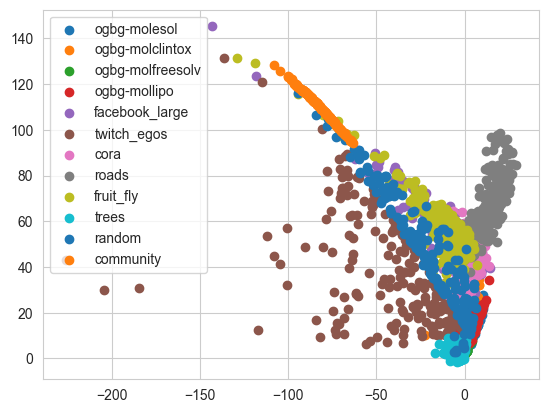

In [114]:
for i, embedding in enumerate(separate_embeddings):
#     print(names[i])
    plt.scatter(embedding[:,0], embedding[:,1], label = names[i])
plt.legend()
print(all_embeddings.shape)
print(len(separate_embeddings), N_per_dataset, np.sum([len(x) for x in separate_embeddings]))

Data(x=[22, 1], edge_index=[2, 46], edge_attr=[46, 1], y=[1, 1])
emb:  (321,)
Graph with 22 nodes and 23 edges


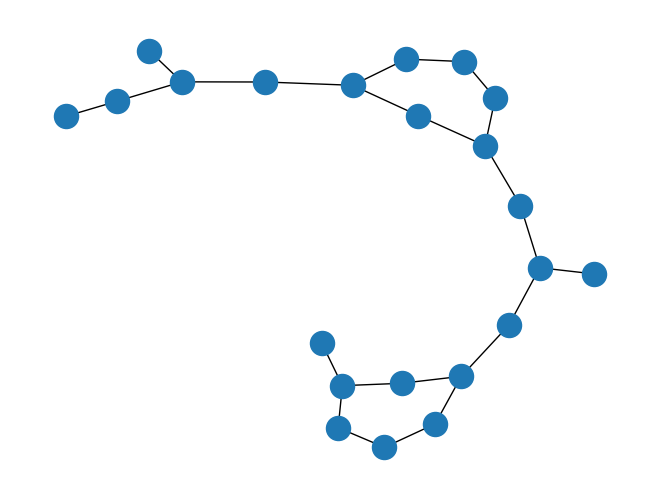

In [45]:
datasetID = 0
gdataset = val_datasets[datasetID]
embdataset = separate_embeddings[datasetID]

graphIDX = 0
graph_i = gdataset[graphIDX]
graph_i_embedding = embdataset[graphIDX]

print(graph_i)
print('emb: ', graph_i_embedding.shape)

g_nx = better_to_nx(graph_i)[0]
print(g_nx)
nx.draw(g_nx)

## Centroid positioning and data SV-decomposition

In [56]:
dataset_centroid_means = np.array([x.mean(axis = 0) for x in separate_embeddings])

In [58]:
dataset_centroid_means.shape

(12, 321)

In [83]:
def getSVD(X, s_only = True):
    # Assuming you have a dataset X with rows as instances and columns as features
    # Compute the mean of each feature
    mean = np.mean(X, axis=0)
    # Center the data
    X_centered = X - mean
    # Compute the covariance matrix
    covariance_matrix = np.cov(X_centered, rowvar=False)

    A = covariance_matrix
    U, s, VT = np.linalg.svd(A)
    if s_only:
        return s
    return U, s

In [84]:
seperate_svds = [getSVD(x) for x in separate_embeddings]

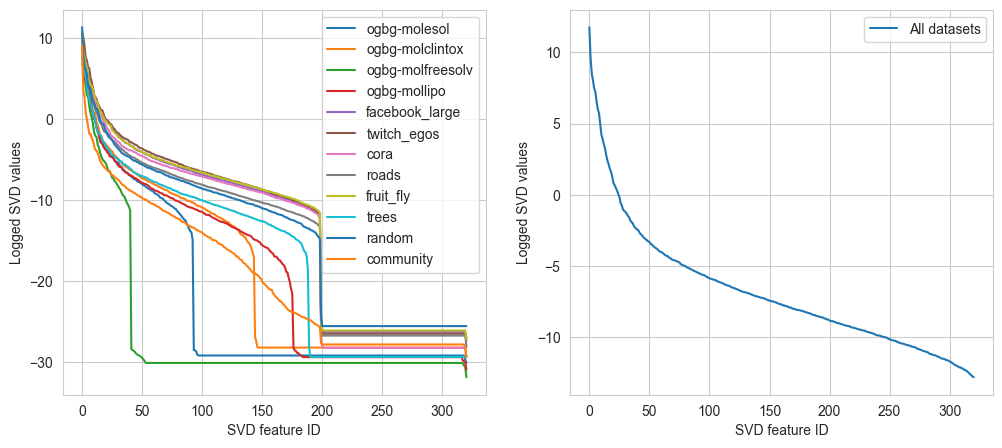

In [112]:
fig, ax = plt.subplots(ncols = 2, figsize = (12,5))
for idx, s in enumerate(seperate_svds):
    s = np.log(s)
    ax[0].plot(s, label = names[idx])
#     plt.show()
all_svd = getSVD(all_embeddings)
logged_all_svd = np.log(all_svd)
ax[1].plot(logged_all_svd, label = 'All datasets')

for a in ax:
    a.set_xlabel('SVD feature ID')
    a.set_ylabel('Logged SVD values')
    a.legend()

In [131]:
true_label = []
for idx, i in enumerate(separate_embeddings):
    for j in i:
        true_label.append(idx)

In [135]:
from sklearn.metrics import adjusted_rand_score
y = kmeans.predict(X)
ari = adjusted_rand_score(true_label, y)

print("Adjusted Rand Index (ARI):", ari)

Adjusted Rand Index (ARI): 0.3735732219319606


/opt/anaconda3/envs/RLenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/RLenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/RLenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/RLenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will c

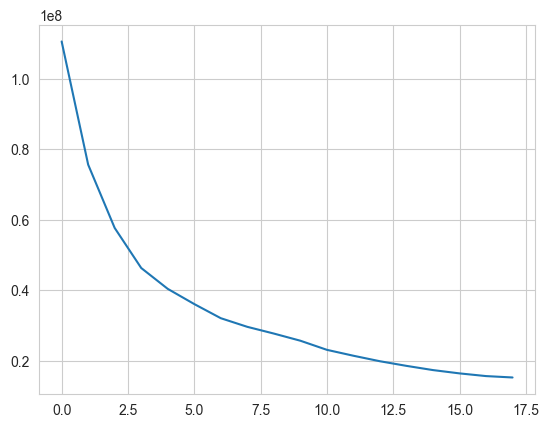

In [139]:
X = all_embeddings

n_clusters = 12
ins = []
for n_clusters in range(2,20):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X, true_label)
    ins.append(kmeans.inertia_)
plt.plot(ins)

/opt/anaconda3/envs/RLenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster Labels:
[9 9 3 ... 4 4 4]
Cluster Centers:
[321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321]


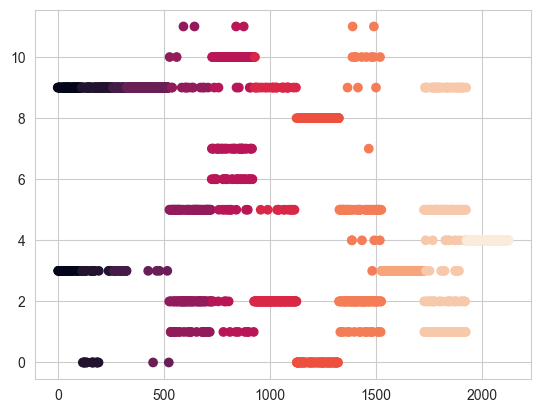

In [144]:
from sklearn.cluster import KMeans

X = all_embeddings

n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X, true_label)

# Get cluster labels for each data point
cluster_labels = kmeans.labels_
# Get cluster centers
cluster_centers = kmeans.cluster_centers_

# Example: Printing the cluster labels
print("Cluster Labels:")
print(cluster_labels)

# Example: Printing the cluster centers
print("Cluster Centers:")
print([len(x) for x in cluster_centers])
plt.scatter(np.arange(len(cluster_labels)),cluster_labels, c = true_label)
plt.show()


In [145]:
cluster_centers

array([[   6.9102993 ,   50.840385  ,  -32.761     , ...,   50.458652  ,
          35.56625   ,   -9.046688  ],
       [ -45.755653  ,   77.35033   ,   44.90956   , ..., -105.10156   ,
          34.78167   ,  -38.082413  ],
       [  -1.3629799 ,   45.835693  ,   -2.0041218 , ...,    0.9970989 ,
          24.077381  ,  -12.98172   ],
       ...,
       [   2.8830643 ,   14.695517  ,  -10.516508  , ...,   15.163769  ,
           9.992797  ,   -3.583912  ],
       [ -23.659613  ,   25.661966  ,   -0.44682598, ...,   11.096075  ,
           5.5578737 ,   -8.380391  ],
       [-126.78214   ,  130.2245    ,  -23.55783   , ..., -145.33817   ,
          21.596922  ,  -75.14229   ]], dtype=float32)

In [146]:
dataset_centroid_means

array([[   1.2289346 ,    8.66815   ,   -8.476659  , ...,   11.491563  ,
           6.0834875 ,   -1.9040153 ],
       [   1.739451  ,   15.148069  ,  -13.826131  , ...,   20.807993  ,
          10.813479  ,   -3.6925027 ],
       [   0.85398394,    4.889231  ,   -5.6615    , ...,    8.153405  ,
           3.9235203 ,   -1.0367607 ],
       ...,
       [  -4.5706487 ,    3.1748567 ,   -8.827943  , ...,   11.616578  ,
           0.4255976 ,    1.3702455 ],
       [ -20.239937  ,   44.609886  ,   28.517998  , ...,  -54.808735  ,
          23.700373  ,  -18.704079  ],
       [ -82.57774   ,  110.04059   ,   80.778366  , ..., -205.01709   ,
          43.46727   ,  -63.80582   ]], dtype=float32)

In [147]:
cluster_distances = pairwise_distances(dataset_centroid_means)

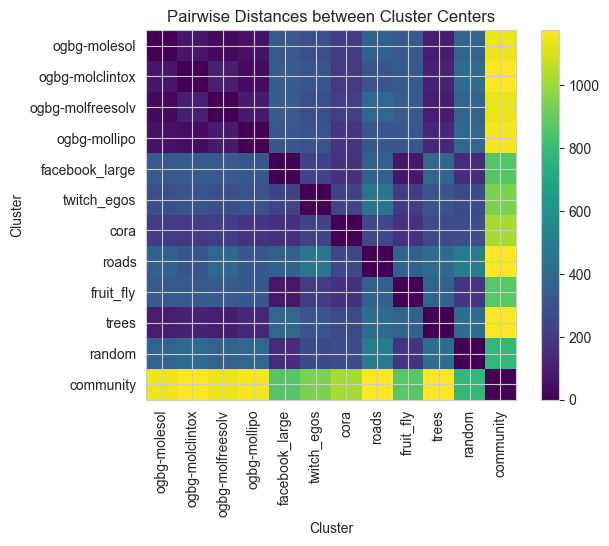

In [155]:
plt.imshow(cluster_distances, cmap='viridis', origin='upper', interpolation='none')
plt.colorbar()
plt.xlabel('Cluster')
plt.ylabel('Cluster')
plt.title('Pairwise Distances between Cluster Centers')
plt.xticks(range(n_clusters), names, rotation = 90)
plt.yticks(range(n_clusters), names, rotation = 0)


plt.show()